
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

# Practico: Curación y Exploración de Datos

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico. 

Dataset: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

In [1]:
#!pip install missingno
#!pip install pyarrow
#!pip install sklearn

In [2]:
import pyarrow
import pyarrow.parquet as pq
import fastparquet
import pandas as pd
import missingno as msno
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import sklearn

from datetime import datetime, date
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from typing import List, Tuple, Union
from hashlib import sha256


In [3]:
sns.set_context(context='talk', font_scale=1.5)

In [4]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
#

In [5]:
def to_categorical(column, bin_size=10, min_cut=0, max_cut=50):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in range(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    print(intervals)
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))

In [6]:
date_regex = r'^(-?(?:[1-9][0-9]*)?[0-9]{4})-(1[0-2]|0[1-9])-(3[01]|0[1-9]|[12][0-9])?$'
match_iso8601 = re.compile(date_regex).match
def validate_iso8601(str_val):
    try:            
        if match_iso8601( str_val ) is not None:
            return True
    except:
        pass
    return False

In [7]:
def calculate_age(row):
    born= row['fecha_nacimiento']
    born = datetime.strptime(born, '%Y-%m-%d')
    fecha_cupon = datetime.strptime(row['fecha_cupon_movimiento'], '%Y-%m-%d')
    return fecha_cupon.year - born.year - ((fecha_cupon.month, fecha_cupon.day) < (born.month, born.day))

In [8]:
def calculate_ant(row):
    antig= row['fecha_de_ingreso_histo']
    antig = datetime.strptime(antig, '%Y-%m-%d')
    fecha_cupon = datetime.strptime(row['fecha_cupon_movimiento'], '%Y-%m-%d')
    return (fecha_cupon.year - antig.year) * 12 + (fecha_cupon.month - antig.month)

#fecha_cupon.year - antig.year - ((fecha_cupon.month, fecha_cupon.day) < (antig.month, antig.day))

In [9]:
def hashit(val: str) -> str:
    return sha256(val.encode('utf-8')).hexdigest()

## Carga DF

In [10]:
df = pd.read_parquet("cupones_ds.parquet")
df=df.sample(1000000, random_state=0)
df_copy= df.copy()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 2745753 to 2398094
Data columns (total 41 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   dni_titular_movimiento               1000000 non-null  object 
 1   moneda_movimiento                    1000000 non-null  int64  
 2   id_comercio_movimiento               1000000 non-null  int64  
 3   nombre_comercio_histo                1000000 non-null  object 
 4   numero_cupon_movimiento              1000000 non-null  int64  
 5   debito_credito_movimiento            1000000 non-null  int64  
 6   producto_naranja_movimiento          1000000 non-null  object 
 7   codigo_empresa_movimiento            1000000 non-null  int64  
 8   tipo_producto_tarjeta_movimiento     1000000 non-null  int64  
 9   plan_movimiento                      1000000 non-null  int64  
 10  fecha_vto_cupon_movimiento           1000000 non-null  objec

## Cuestiones de la Parte 1:

#### Agregamos columna de mes-año.

In [12]:
fecha='fecha_cupon_movimiento'
#Convertimos la columna de fecha a datetime
df.loc[:, 'fecha_datetime'] = df[fecha].apply(lambda fecha: datetime.strptime(fecha, '%Y-%m-%d'))
#Creamos una nueva columna para mostrar el año y la fecha en una nueva columna (para poder hacer el merge con la tabla inflacionaria)
fecha='fecha_datetime'
df.loc[:, 'mes'] = df[fecha].apply(lambda fecha: datetime.strftime(fecha, '%Y-%m'))
df.loc[:, 'año'] = df[fecha].apply(lambda fecha: datetime.strftime(fecha, '%Y'))
df[:3]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,fecha_datetime,mes,año
2745753,00060322d46ef99decf79257957b934d413,0,20099745,SERVICIO NARANJA A CELULARES,999991,0,SM,1,0,1,...,MAR DEL PLATA,7603.0,DEL PUERTO,2016-08-23,SIN DATOS,SECUNDARIOS,Propia,2021-02-25,2021-02,2021
2669472,0003c4ca152c877c9d5c9753674a266e571,3,141018751,FARMACIA BARBIERI 1,2901,0,PL,1,3,1,...,FEDERACION,3206.0,E.RIOS,2006-03-23,DOCENTE,TERCIARIOS,Propia,2021-03-04,2021-03,2021
1651880,00004afe8d04749bc63852cd1c44fcae019,0,260003502,TRIUNFO COOPERATIVA DE SEGUROS,563743,0,PL,1,3,1,...,EL RESGUARDO,5543.0,COVIRPOL,1997-04-25,SIN DATOS,SECUNDARIOS,De familiar,2020-10-21,2020-10,2020


#### Preparación del monto_compra_movimiento.

**Inflación:** Cuando en Argentina hablamos de pesos a lo largo del tiempo, no debemos pasar por alto la inflación. Brevemente explicado, la inflación es lo que hace que, por ejemplo, 100 pesos en 02/2020 no valga lo mismo que 100 pesos en 05/2021 (los $ 100 de 05/2021 te permite comprar menos que el de 02/2020).
Por esto consideramos fundamental para analizar el monto homogenizar la moneda, ajustando dichos montos por un coeficiente de ajuste por inflación.
Elegimos utilizar un indice publico que brinda la Federación Argentina de Consejos Profesionales de Ciencias Económicas.
El metodo seleccionado para ajustar es ajustar los valores pasados para traer su equivalente en el ultimo mes de movimiento (05/2021).

Fuente: https://www.facpce.org.ar/indices-facpce/

**Dolares:** A su vez el dataset posee movimientos en dolares, otro aspecto que debemos considerar a la hora de comprar montos. decidimos convertir los valores en dolares a pesos. Para esto utilizamos el  tipo de cambio del Banco Nación, con todos los impuestos (30% + 35 %), del día del ultimo movimiento. Eso hace que no solo convierta en pesos sino tambien lo ajusta al valor de hoy, por lo que a estos valores no se debería aplicar el ajuste por inflación.

https://www.bna.com.ar/Personas

In [13]:
#rango de Fechas
df.mes.min(),df.fecha_cupon_movimiento.max()

('2020-02', '2021-05-25')

In [14]:
tabla_inflacion= [
    ['2020-01',1.617],
    ['2020-02',1.585],
    ['2020-03',1.534],
    ['2020-04',1.511],
    ['2020-05',1.488],
    ['2020-06',1.456],
    ['2020-07',1.428],
    ['2020-08',1.391],
    ['2020-09',1.352],
    ['2020-10',1.303],
    ['2020-11',1.263],
    ['2020-12',1.215],
    ['2021-01',1.167],
    ['2021-02',1.127],
    ['2021-03',1.075],
    ['2021-04',1.033],
    ['2021-05',1.000]
]

ind_inflacion = pd.DataFrame(tabla_inflacion, columns = ['mes', 'ind_inflacion'])

In [15]:
tc_usd=155.892
df = df.merge(ind_inflacion, on='mes')

def normalizar_monto(monto, multiplicador, moneda):
    #Acá deberíamos pasar también la moneda y la cotización
    if moneda == 1:
      return monto * tc_usd
    return monto * multiplicador

df.loc[:, 'monto_normalizado'] = df[['monto_compra_movimiento', 'ind_inflacion','moneda_movimiento']].apply(lambda row: normalizar_monto(row['monto_compra_movimiento'], row['ind_inflacion'], row['moneda_movimiento']), axis=1).round(2)

# 1. Curación
Con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático

* Asegurar IDs únicos
  > Ejm. `id_comercio_movimiento` le corresponde un mismo `nombre_comercio_histo`?
* Asegurar que el codigo postal tenga el tipo de datos correcto.
* Tratamiento de valores Sensibles
  > Ejm. cuando se tienen datos como el DNI, CUIL o Nro de Tarjetas correponde a datos confidenciales
  - Codifcar los valores usando el algoritmo `sha256` con la libreria `hashlib`
* Reemplazar caracteres especiales. Ejm
  ```
  ñ. Ñ. ~. ç. Ç. á. é. í. ó. ú. Á. É. Í. Ó. Ú. ü. Ü.
  @. ¡ ! ¿ ? ⁄. \. °. —. (. ) [. ] {. } 〈. 〉 ‹ › <. > 
  〔. 〕 « » ¹. ². ³ … ˜. §. ¶.  †. “ ” ∞. µ. à.
  ```
* Asegurar que las fechas tengan el formato ISO 8601, `YYYY-MM-DD`
* Agrupar valores de `cargo_descripcion_histo`.
  > Ejm. si tenemos un valor con`vigilador` y otro `sereno`, estos corresponden a una misma categoria., 

##  A) ID Unicos

* Asegurar IDs únicos
  > Ejm. `id_comercio_movimiento` le corresponde un mismo `nombre_comercio_histo`?

#### Curación de la variable
Antes de prodecer al analisis, vamos a corregir el tipo de datos y los posibles errores que pueden contener al ser importado como un integer cuando corresponde ser un string.

In [16]:
#Convierto a tipo de dato string
df.loc[:,'id_comercio_movimiento']=df.id_comercio_movimiento.astype(str)
df.dtypes[2:3]

id_comercio_movimiento    object
dtype: object

In [17]:
#consulto longitudes de los textos
df.id_comercio_movimiento.str.len().unique()

array([8, 9], dtype=int64)

In [18]:
#completamos con 0 adelnate de la cadena a cada valor que tiene menos de 9 dígitos.
df.loc[:,'id_comercio_movimiento_ok']=df.id_comercio_movimiento.str.zfill(9).astype(str)
df.id_comercio_movimiento_ok.str.len().unique()

array([9], dtype=int64)

#### Analisis de Valores Unicos

In [19]:
print(df.id_comercio_movimiento.nunique(), df.nombre_comercio_histo.nunique())

3833 7059


In [20]:
groups = df.groupby(["id_comercio_movimiento", "nombre_comercio_histo"]).count()
groups[:10]

dni_titular_movimiento  \
id_comercio_movimiento nombre_comercio_histo                                              
100000237              TS TIENDAS                                                    13   
                       TS TIENDAS                                                     6   
100002423              CASA DE PEDRO                                                 25   
                       CASA DE PEDRO                                                  9   
100003130              GRIMOLDI CENTRO                                               34   
                       GRIMOLDI CENTRO                                                7   
100005898              FERNIPLAST                                                   326   
                       FERNIPLAST                                                    56   
100006572              EL MUNDO DEL LIBRO S.R.L                                      12   
                       EL MUNDO DEL LIBRO S.R.L                                       1   

                                                                 moneda_movimiento  \
id_comercio_movimiento nombre_comercio_histo                                         
100000237              TS TIENDAS                                               13   
                       TS TIENDAS                                                6   
100002423              CASA DE PEDRO                                            25   
                       CASA DE PEDRO                                             9   
100003130              GRIMOLDI CENTRO                                          34   
                       GRIMOLDI CENTRO                                           7   
100005898              FERNIPLAST                                              326   
                       FERNIPLAST                                               56   
100006572              EL MUNDO DEL LIBRO S.R.L                                 12   
                       EL MUNDO DEL LIBRO S.R.L                                  1   

                                                                 numero_cupon_movimiento  \
id_comercio_movimiento nombre_comercio_histo                                               
100000237              TS TIENDAS                                                     13   
                       TS TIENDAS                                                      6   
100002423              CASA DE PEDRO                                                  25   
                       CASA DE PEDRO                                                   9   
100003130              GRIMOLDI CENTRO                                                34   
                       GRIMOLDI CENTRO                                                 7   
100005898              FERNIPLAST                                                    326   
                       FERNIPLAST                                                     56   
100006572              EL MUNDO DEL LIBRO S.R.L                                       12   
                       EL MUNDO DEL LIBRO S.R.L                                        1   

                                                                 debito_credito_movimiento  \
id_comercio_movimiento nombre_comercio_histo                                                 
100000237              TS TIENDAS                                                       13   
                       TS TIENDAS                                                        6   
100002423              CASA DE PEDRO                                                    25   
                       CASA DE PEDRO                                                     9   
100003130              GRIMOLDI CENTRO                                                  34   
                       GRIMOLDI CENTRO                                                   7   
100005898              FERNIPLAST                                                 

#### Quitamos espacios:
Se pueden ver que hay varios id que tienen el mismo nombre pero estan separados, pudimos notar que eso se debe a que al final de los strings poseen espacios en blancos que dificultan su analisis, procedemos a eliminarlos.

In [21]:
groups.reset_index().values[1][1], groups.reset_index().values[2][1]

('TS TIENDAS                              ', 'CASA DE PEDRO')

In [22]:
df.loc[:, "nombre_comercio_histo_ok"] = df.nombre_comercio_histo.str.strip()

In [23]:
print(df.id_comercio_movimiento.nunique(), df.nombre_comercio_histo_ok.nunique())

3833 3707


In [24]:
#Encontramos distintos nombre de comercio para el mismo id (nombres similares que vamos a reemplazar por uno)
groups2 = df[["id_comercio_movimiento", "nombre_comercio_histo_ok",'monto_compra_movimiento']].groupby(["id_comercio_movimiento"]).nunique()
groups2=groups2.sort_values(by='nombre_comercio_histo_ok', ascending=False)

groups2[groups2['nombre_comercio_histo_ok']>1]

,nombre_comercio_histo_ok,monto_compra_movimiento
id_comercio_movimiento,,
262002246,4,16
100473575,4,7
260028472,3,1
630044993,3,1
114009772,3,1
...,...,...
112122929,2,1
120012388,2,1
562075113,2,1


In [25]:
#Ejemplo:
ver= df[df['id_comercio_movimiento']=="262002246"].groupby(['nombre_comercio_histo_ok']).count()[['monto_compra_movimiento']].sort_values(by='monto_compra_movimiento', ascending=False)
ver.reset_index()['nombre_comercio_histo_ok']

0                         ATMCIASEG
1               ATM CIA. DE SEGUROS
2    ASEGURADORA TOTAL MOTOVEHICULA
3            COMUNIDAD MOTOCICLISTA
Name: nombre_comercio_histo_ok, dtype: object

In [26]:
for group in groups2.reset_index()['id_comercio_movimiento']:
    #print(group)
    id_comercio= group
    df_unico_nombre= df[df['id_comercio_movimiento']==id_comercio].groupby(['nombre_comercio_histo_ok']).count()[['monto_compra_movimiento']].sort_values(by='monto_compra_movimiento', ascending=False)
    df_unico_nombre=df_unico_nombre.reset_index()
    #print(df_unico_nombre[:1]['nombre_comercio_histo_ok'])
    #print(df_unico_nombre[:1]['nombre_comercio_histo_ok'].values[0])
    df.loc[df['id_comercio_movimiento']==group, 'nombre_comercio_histo_ok'] = df_unico_nombre[:1]['nombre_comercio_histo_ok'].values[0]

In [27]:
ver= df[df['id_comercio_movimiento']=='262002246'].groupby(['nombre_comercio_histo_ok']).count()[['monto_compra_movimiento']].sort_values(by='monto_compra_movimiento', ascending=False)
ver.reset_index()['nombre_comercio_histo_ok']

0    ATMCIASEG
Name: nombre_comercio_histo_ok, dtype: object

In [28]:
df.shape

(1000000, 48)

#### Conclusión: 
Luego de haber limpiado los espacios en blanco de los nombre de los comercios, nos encontramos con 190 id de comercio que contaban con mas de 1 nombre. Luego de visualizar algunos ejemplos nos dimos cuenta que si bien son nombres distintos refieren al mismo comercio. Por lo que decidimos reemplazar el nombre por el del local con mayor frecuencia.

## B) Tipo dato Cod. Postal.

* Asegurar que el codigo postal tenga el tipo de datos correcto.

Se puede ver que le codigo postal es un dato float64, lo que nos parece inadecuado. El codigo postal si bien es un dato numerico, este no va a utilizar las propiedades y/o funciones de los numeros en sí, como por ejemplo: suma, resta, multiplicación,etc. Además al dejarlo como número si existen valores con el caracter 0 adelante se borrarían y no es lo que queremos para esta variable.
Procedemos a cambiarlo a string. 
Si bien esta variable no va a formar parte de nuestro dataset final, la convertimos para imputar los valores de provincia faltantes mediante esta.

In [29]:
#convierto a string
df.loc[:,'domicilio_codigo_postal']=df.domicilio_codigo_postal.astype(str)

In [30]:
df.dtypes[35:36]

domicilio_codigo_postal    object
dtype: object

#### Valores Erroneos: 
Los códigos postales en Argentina tienen 4 dígitos, por lo que los valores que tienen menos que estos son considerados errores. (Luego serán reimputados).

In [31]:
#controlamos que todos los codigos postales tengan la misma longitud
df.domicilio_codigo_postal.str.len().unique()

array([6, 3, 5], dtype=int64)

In [32]:
# Filtrar datos con codigos postales menores a 6 digitos. A reimputar
df[df.domicilio_codigo_postal.str.len()<6]['domicilio_codigo_postal'].count()

8394

## C) Valores Sensibles


* Tratamiento de valores Sensibles
  > Ejm. cuando se tienen datos como el DNI, CUIL o Nro de Tarjetas correponde a datos confidenciales
  - Codifcar los valores usando el algoritmo `sha256` con la libreria `hashlib`
 

In [33]:
#generamos una muestra para aplicar el procedimiento.
df_hash= df.sample(1000)[['dni_titular_movimiento']]


In [34]:
df_hash.loc[:,'dni_hash']= df_hash['dni_titular_movimiento'].apply(hashit)
df_hash

,dni_titular_movimiento,dni_hash
844887,0002f2e68554a2b49c29db31b595bd75369,15e76276c46c7e7c16616539fcc98c792b2c4dddd7c299...
388871,0002c69a68993c210b53cfbb0449495e277,76621629c02e8e54557160298091f91700c15d42937b50...
846098,0004ab25a6402e18feecb0abcce1cb05368,6e10e7c5b82258d61a8c4d9871da9df96d2f2df6ee917d...
648722,000390b9a220c0ee2431acfd8a36169b800,5e20f5ec5ec36addc921faafc1af1afc3afb4bb3b5adf5...
616650,0008b071ffe34d4a2b700365f1bcdfdc002,3caf9048f90c188efbb56c056906ff375f3fec74ab10b4...
...,...,...
937042,00057475356d4a42fdc70e36893960d7770,be289b2ede019601880c4e20e70393dc091adbac084235...
801225,0009d755757673758d8a50f3e0a7d346850,543322447132e4af6c13b75090f77b41b2fa8ac0243af1...
129139,0002716f6d9c2130a8c88a0219de234d459,72c1fb20819cfac27f2047e06dfd1415d53804f6330036...
1617,00074a51b366f3ea8fba2bdfa7bc1fc2196,e0fc0ed58708a11abbea08dfbe53403f6dfa9b028d8872...


## D) Caracteres Especiales

* Reemplazar caracteres especiales. Ejm
  ```
  ñ. Ñ. ~. ç. Ç. á. é. í. ó. ú. Á. É. Í. Ó. Ú. ü. Ü.
  @. ¡ ! ¿ ? ⁄. \. °. —. (. ) [. ] {. } 〈. 〉 ‹ › <. > 
  〔. 〕 « » ¹. ². ³ … ˜. §. ¶.  †. “ ” ∞. µ. à.

In [35]:
df = df.replace(["á","Á","é","É","í","Í","ó","Ó","ú","ü","Ú","Ü",r"[/_<>ñÑ~çÇ@¡!¿?«»¹²³…˜§¶†”∞µà⁄°—()${}〈〉‹›<>〔〕]"],["a","A","e","E","i","I","o","O","u","u","U","U",""], regex=True)
#df = df.replace(r"[./_<>ñÑ~çÇ@¡!¿?«»¹²³…˜§¶†”∞µà⁄°—()${}〈〉‹›<>〔〕]","", regex=True)
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,fecha_datetime,mes,año,ind_inflacion,monto_normalizado,id_comercio_movimiento_ok,nombre_comercio_histo_ok
0,00060322d46ef99decf79257957b934d413,0,20099745,SERVICIO NARANJA A CELULARES,999991,0,SM,1,0,1,...,SIN DATOS,SECUNDARIOS,Propia,2021-02-25,2021-02,2021,1.127,84.55,020099745,SERVICIO NARANJA A CELULARES
1,0009d755757673758d8a50f3e0a7d346850,0,20099804,ZETA,951637,0,ZE,1,3,6,...,ADMINISTRATIVO,SECUNDARIOS,De familiar,2021-02-06,2021-02,2021,1.127,11036.67,020099804,ZETA
2,00096c5dcd37d47c7bf5bf616361aed6195,0,100309933,GALICIA SEGUROS HOGAR,526658,0,PL,1,3,1,...,SIN DATOS,UNIVERSITARIOS,Propia,2021-02-22,2021-02,2021,1.127,857.49,100309933,GALICIA SEGUROS HOGAR
3,0006437a1e51d3deadb19798afdab561872,0,20099760,INT.PAGO FUERA TERMINO,201904,1,PL,1,0,1,...,MAESTRANZA,PRIMARIOS,Propia,2021-02-12,2021-02,2021,1.127,-81.12,020099760,INT.PAGO FUERA TERMINO
4,0003eb8b2f098f2f50fff2d50f351fa8207,0,30090504,TARJETA NARANJA MAR DEL PLATA,741413,0,PL,1,3,1,...,INDEPENDIENTE,SECUNDARIOS,Propia,2021-02-04,2021-02,2021,1.127,26.79,030090504,TARJETA NARANJA MAR DEL PLATA


## E) Formato Fechas
* Asegurar que las fechas tengan el formato ISO 8601, `YYYY-MM-DD`

In [36]:
df[df['fecha_cupon_movimiento'].apply(validate_iso8601)==False]
#df[df['fecha_nacimiento'].apply(validate_iso8601)==False]
#df[df['fecha_de_ingreso_histo'].apply(validate_iso8601)==False] 

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,fecha_datetime,mes,año,ind_inflacion,monto_normalizado,id_comercio_movimiento_ok,nombre_comercio_histo_ok


#### Conclusión:
Comprobamos que todas las fechas cumplen con el formato ISO 8601, YYYY-MM-DD. 
El control se realizó solamente en las columnas fecha_cupon_movimeinto, fecha_de_ingreso_histo y en fecha_nacimiento ya que son las únicas quye se van a utilizar en el análisis.
Podemos ver que en fecha_nacimiento encontramos 10551 filas que no cumplen con el formato ya que son valores en blanco, mas adelante se resolverá este tema de faltantes.

## F) Agrupar Valores - cargo_descripción_histo

* Agrupar valores de `cargo_descripcion_histo`.
  > Ejm. si tenemos un valor con`vigilador` y otro `sereno`, estos corresponden a una misma categoria., 

In [37]:
df['cargo_descripcion_histo'].unique()

array(['SIN DATOS', 'ADMINISTRATIVO', 'MAESTRANZA', 'INDEPENDIENTE',
       'PROPIETARIO', 'DOCENTE', 'EMP.DE COMERCIO', 'OPERARIO',
       'JUBILADO', 'CHOFER', 'VIGILADOR', 'PRES.T.CREDITO', 'ENFERMERO',
       'EMP.SEG.PUBLICA', 'CAJERO', 'JEFE', 'VENDEDORPROMOT',
       'PROFESTECNICO', 'PRES.GARANTIA', 'ENCARGADO', 'MOZO', 'COCINERO',
       'PORTEROCONSERJ', 'MEDICO', 'PEONEMBARCADOS'], dtype=object)

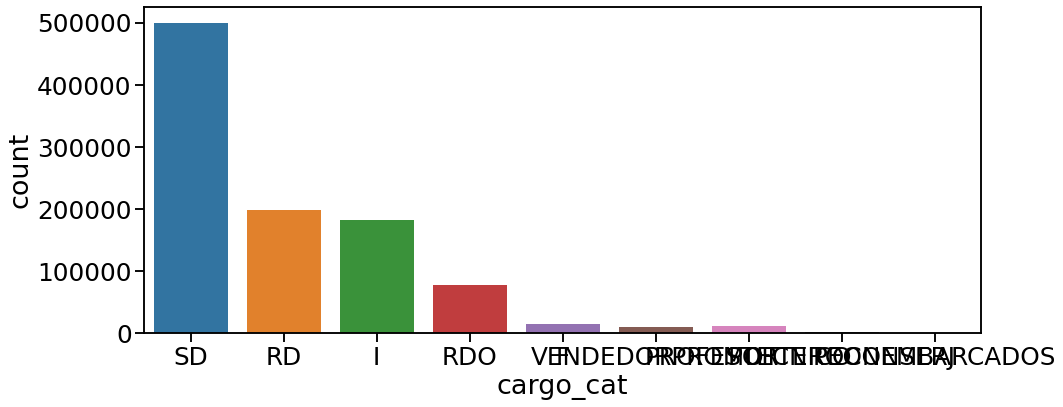

In [38]:
new_cats = {'EMP.DE COMERCIO':'RD',
'ADMINISTRATIVO':'RD',
'CHOFER':'RD',
'MAESTRANZA':'RD',
'VENDEDOR/PROMOT':'RD',
'OPERARIO':'RDO',
'ENFERMERO':'RDO',
'MOZO':'RDO',
'ENCARGADO':'RDO',
'PEON/EMBARCADOS':'RDO',
'JEFE':'RDO',
'CAJERO':'RD',
'COCINERO':'RDO',
'INDEPENDIENTE':'I',
'PROPIETARIO':'I',
'PROFES/TECNICO':'I',
'MEDICO':'I',
'DOCENTE':'I',
'JUBILADO':'I',
'EMP.SEG.PUBLICA':'RDO',
'VIGILADOR':'RDO',
'PORTERO/CONSERJ':'RDO',
'SIN DATOS':'SD',
'PRES.T.CREDITO':'F',
'PRES.GARANTIA':'F'}

df.loc[:,'cargo_cat']= df['cargo_descripcion_histo'].replace(new_cats)
fig=plt.figure(figsize=(15,6))
sns.countplot(data=df,x='cargo_cat')
plt.ticklabel_format(style='plain', axis='y')


#### Conclusión: 
Luego de observar la composición de la variable cargo_descripcion_histo, decidimos agruparlos en 5 categorías.
> A saber:
> - **RD:** Relación de dependencia - Empleados de Comercio (decidimos crear una categoría solo con estos valores ya que por conocimiento de dominio y por visualización de los datos sabemos que son mas numerosas que el resto de los sindicatos).
> - **I:** Profesiones Independientes.
> - **SD:** Sin Datos.
> - **F:** Financieros.
> - **RDO:** Relación de dependencia - Otros.

**Metodo:** Por conocimiento de dominio.

# 2. Data enrichment
* obtener edad usando la columna `fecha_nacimiento` y `fecha_cupon_movimiento`
* obtener antiguedad usando la columna `fecha_de_ingreso_histo` y `fecha_cupon_movimiento` en termino de meses
* usando la columna `nombre_comercio_histo` crear una nueva columna clasificando el tipo de "comercio". Ejemplo 
   ```
     COMISION POR MANTENIM.DE CTA., IMPUESTO SELLOS, INT.PAGO FUERA TERMINO ------> Categoria A
     MERCADO PAGO, DESPEGAR.COM                                             ------> Categoria B
   ```
   > Crear un minimo de 5 categorias
* se puede aplicar el proceso anterior a la columna `nombre_local_histo` y `cargo_descripcion_histo`. Aportaria informacion relevante?

## A) Obtener edad.

* obtener edad usando la columna `fecha_nacimiento` y `fecha_cupon_movimiento`

In [39]:
df.loc[:, 'edad'] = df[df["fecha_nacimiento"].notnull()].apply(calculate_age,axis=1)

In [40]:
df['edad'].unique()

array([ 32.,  54.,  60.,  59.,  36.,  51.,  26.,  53.,  39.,  38.,  41.,
        49.,  30.,  27.,  47.,  31.,  40.,  72.,  35.,  33.,  61.,  29.,
        66.,  50.,  46.,  43.,  37.,  44.,  62.,  56.,  63.,  67.,  65.,
        71.,  76.,  79.,  28.,  68.,  48.,  42.,  34.,  57.,  58.,  82.,
        52.,  78., 109.,  75.,  55.,  45.,  64.,  77.,  69.,  70.,  73.,
        74.,  24.,  80.,  20.,  88.,  25.,  18.,  81.,  22.,  85.,  91.,
        nan,  83.,  21., 100.,  87.,  90.,  23.,  84., 108.])

## B)  Obtener Antiguedad.

* obtener antiguedad usando la columna `fecha_de_ingreso_histo` y `fecha_cupon_movimiento` en termino de meses

In [41]:
# en termino de meses.
df.loc[:, 'antig'] = df[df["fecha_de_ingreso_histo"].notnull()].apply(calculate_ant,axis=1)

In [42]:
df['antig'].unique()

array([ 54, 184,  20, 123, 118, 199,  58, 196,  84,  44, 101,  80, 121,
       127,  63,  36,  61,  49, 280, 181, 178,  28, 124,   9, 271,   8,
       119, 170, 116, 131,   3,   2,  92,  98,  59,  31, 133,  26,  93,
        97,  35, 203,  57,  90, 115,  82, 157,  42, 150, 111, 149, 112,
       114,  52, 284,   1,  48, 107,  40, 363, 155, 204,  45, 108, 185,
       251, 145,  85,  68, 160, 156,   6, 120, 244, 152, 286,  64, 186,
       144,  41,  22, 135, 248,   4, 193, 254,  69,  16, 158, 136, 117,
        33, 233, 232, 192,  25, 164,  27,  72, 140, 182,  83,  78, 243,
       183,  91,  14, 141,  79, 171,  71,  17,  74,  43, 236, 200, 273,
       128, 143, 222, 102, 173, 285, 125, 137,  60,  95, 100, 268, 110,
        46,  94, 175,  34,  62, 281,  23, 257, 113, 215,  21, 147, 154,
        65,  18,  11, 252, 122,  29, 287, 162,  24, 220,  39, 239,  32,
        30,  81, 245, 241, 166,  88, 139, 105,  56,  66, 246, 167, 207,
        96, 290, 288, 179, 174, 168,  73,  50,  89, 275,  70, 12

In [43]:
df.shape

(1000000, 51)

## C) Categorías Nombre Comercio.

* usando la columna `nombre_comercio_histo` crear una nueva columna clasificando el tipo de "comercio". Ejemplo 
   ```
     COMISION POR MANTENIM.DE CTA., IMPUESTO SELLOS, INT.PAGO FUERA TERMINO ------> Categoria A
     MERCADO PAGO, DESPEGAR.COM                                             ------> Categoria B
   ```
   > Crear un minimo de 5 categorias


#### Metodo: 
Para agrupar esta categoría utilizamos un criterio que utiliza la empresa a la hora de agrupar los comercios, esta es mediante los 3 primeros dígitos del id. de comercio).

In [44]:
df.nombre_comercio_histo_ok.nunique()

3587

In [45]:
#tomamos los 3 primeros dígitos. Se hace prueba con un digito para acortar las columnas (no da la compu)
#df.loc[:,'cat_comercio']=df.id_comercio_movimiento_ok.astype('string').str[0:3]
df.loc[:,'cat_comercio']=df.id_comercio_movimiento_ok.astype('string').str[0]
df.cat_comercio.nunique()


10

In [46]:
df.groupby(['cat_comercio','nombre_comercio_histo_ok']).count()

dni_titular_movimiento  \
cat_comercio nombre_comercio_histo_ok                                 
0            APP NARANJA                                         51   
             APP NARANJA TARJETA DEBITO PLA                      47   
             APP NARANJA-TARJETA DEBITO PP                       59   
             ATM 1- ALTA CORDOBA                                 19   
             AVENGERS                                           899   
...                                                             ...   
9            WALMART COMODORO RIVADAVIA                         105   
             WALMART COMODORO RIVADAVIA 2                        15   
             WALMART SAN JUSTO                                   59   
             YENNY COMODORO RIVADAVIA                            17   
             YPF COMODORO RIVADAVIA                              18   

                                             moneda_movimiento  \
cat_comercio nombre_comercio_histo_ok                            
0            APP NARANJA                                    51   
             APP NARANJA TARJETA DEBITO PLA                 47   
             APP NARANJA-TARJETA DEBITO PP                  59   
             ATM 1- ALTA CORDOBA                            19   
             AVENGERS                                      899   
...                                                        ...   
9            WALMART COMODORO RIVADAVIA                    105   
             WALMART COMODORO RIVADAVIA 2                   15   
             WALMART SAN JUSTO                              59   
             YENNY COMODORO RIVADAVIA                       17   
             YPF COMODORO RIVADAVIA                         18   

                                             id_comercio_movimiento  \
cat_comercio nombre_comercio_histo_ok                                 
0            APP NARANJA                                         51   
             APP NARANJA TARJETA DEBITO PLA                      47   
             APP NARANJA-TARJETA DEBITO PP                       59   
             ATM 1- ALTA CORDOBA                                 19   
             AVENGERS                                           899   
...                                                             ...   
9            WALMART COMODORO RIVADAVIA                         105   
             WALMART COMODORO RIVADAVIA 2                        15   
             WALMART SAN JUSTO                                   59   
             YENNY COMODORO RIVADAVIA                            17   
             YPF COMODORO RIVADAVIA                              18   

                                             nombre_comercio_histo  \
cat_comercio nombre_comercio_histo_ok                                
0            APP NARANJA                                        51   
             APP NARANJA TARJETA DEBITO PLA                     47   
             APP NARANJA-TARJETA DEBITO PP                      59   
             ATM 1- ALTA CORDOBA                                19   
             AVENGERS                                          899   
...                                                            ...   
9            WALMART COMODORO RIVADAVIA                        105   
             WALMART COMODORO RIVADAVIA 2                       15   
             WALMART SAN JUSTO                                  59   
             YENNY COMODORO RIVADAVIA                           17   
             YPF COMODORO RIVADAVIA                             18   

                                             numero_cupon_movimiento  \
cat_comercio nombre_comercio_histo_ok                                  
0            APP NARANJA                                          51   
             APP NARANJA TARJETA DEBITO PLA                       47   
             APP NARANJA-TARJETA DEBITO PP                        59   
             ATM 1- ALTA CORDOBA                                  1

## D) Otras Categorías.

* se puede aplicar el proceso anterior a la columna `nombre_local_histo` y `cargo_descripcion_histo`. Aportaria informacion relevante?

Se le podría aplicar un proceso similar a dichas columnas.
Pero la columna **nombre_local_histo** (como se puede ver mas abajo) posee muchos valores en blanco por lo que no se va a utilizar en el analisis.
A la columna **cargo_descripcion_histo** ya se le hizo una agrupación en un punto anterior.

>* Otras Columnas a Agrupar:
>  - **Edad:** por rango de edad.
>  - **Antiguedad:** por rango de antiguedad (en años).
>  - **Estado Civil:** Agrupar categorías menos frecuentes.
>  - **Rel Vivienda:** Agrupar categorías menos frecuentes.
>  - **Tipo Producto:** Agrupar categorías menos frecuentes.

# 3. Exploración

* Analisis de valores Nulos
  - Existen columnas en donde se prodria hacer imputacion de valores? Si es asi, imputar los valores.
  - Para aquellos en donde no aplique lo primero, conviene eliminarlos o agruparlos como otro valor?
* Identificar valores atípicos.
  * Para variables numericas, analisis de outliers. En que caso se pueden eliminar estos valores?
  * Para variables categoricas, se pueden agrupar estos valores en una nueva categoria?
    > Ejm. `cargo_descripcion_histo`
  * Para fechas. existen fechas atipicas?
    > Ejm. Una fecha con el valor `2021-12-03`, sabiendo que el dataset deberia tener  datos entre julio 2020 y mayo 2021 
* Se puede normalizar la antiguedad y/o `monto_compra_movimiento`?
* Usando la edad y la antiguerdad hacer una analisis de PCA junto con la variables `monto_compra_movimiento`
  > pueden usar las 3 variables o hacer un analisis edad - monto y antiguedad - monto.

## A) Valores Nulos.

* Analisis de valores Nulos
  - Existen columnas en donde se prodria hacer imputacion de valores? Si es asi, imputar los valores.
  - Para aquellos en donde no aplique lo primero, conviene eliminarlos o agruparlos como otro valor?

### Analisis Nulos

In [47]:
df.isna().sum()

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento          342982
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

In [48]:
# se obtienen los nombres de las categorías con nulos.
cols_isna=df.isna().any()
cols_isna= df.columns[cols_isna].tolist()
cols_isna

['fecha_carga_sistema_movimiento',
 'tipo_prestamo_movimiento',
 'nombre_local_histo',
 'fecha_extraccion_movimiento',
 'fecha_nacimiento',
 'sexo_descripcion',
 'pais',
 'provincia',
 'ciudad',
 'domicilio_barrio',
 'nivel_estudio_descripcion_histo',
 'rel_vivienda_descripcion_histo',
 'edad']

<AxesSubplot:>

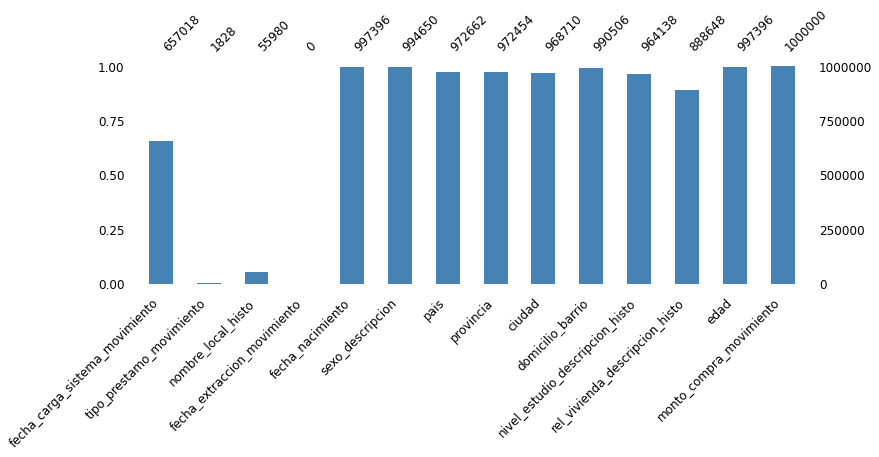

In [49]:
cols_isna=cols_isna +  ['monto_compra_movimiento']

msno.bar(df[cols_isna],figsize=(12, 4), fontsize=12, color='steelblue')

<AxesSubplot:>

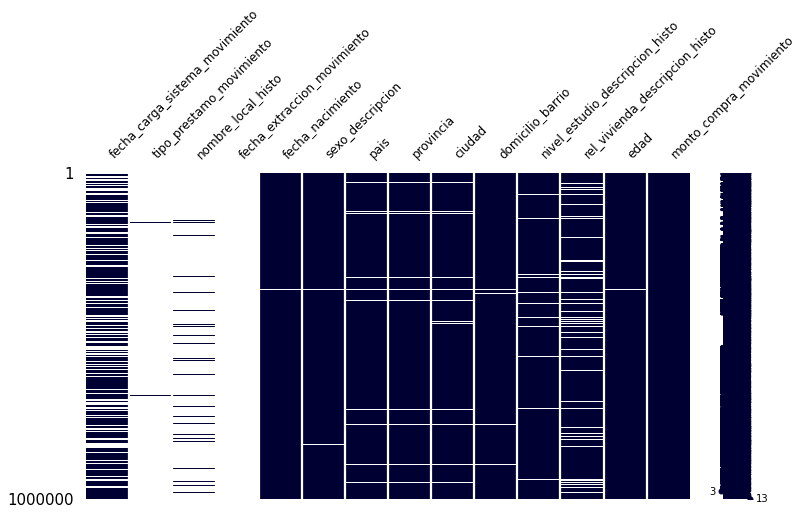

In [50]:
df_sample= df[cols_isna]
msno.matrix(df_sample,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

### Imputación de variables:

#### Provincia:
Para reimputar esta variable vamos a realizar dos pasos:
- Imputar los faltantes de codigo postal.
- imputar los faltantes de provincia según el código postal.

La variable codigo postal no es tenida en cuenta luego de esta imputación.

In [51]:
# Creamos tabla con CP y Provincia.
codigos_postales_to_replace = df[df['provincia'].isna()]['domicilio_codigo_postal'].unique().tolist()
codigos_postales_to_replace.remove('0.0')
codigos_postales_to_replace.remove('nan')
#codigos_postales_to_replace.remove('400.0')

provincias_por_cp = df[df['domicilio_codigo_postal'].isin(codigos_postales_to_replace)][['domicilio_codigo_postal', 'provincia']].groupby(['domicilio_codigo_postal', 'provincia']).count()
provincias_por_cp

,
domicilio_codigo_postal,provincia
1663.0,BUENOS AIRES
3300.0,MISIONES
3500.0,CHACO
3503.0,CHACO
4000.0,TUCUMAN
4101.0,TUCUMAN
5000.0,CORDOBA
5002.0,CORDOBA
5014.0,CORDOBA


In [52]:
codigos_postales_to_replace = df[df['provincia'].isna()]['domicilio_codigo_postal'].unique().tolist()
codigos_postales_to_replace

['9100.0',
 'nan',
 '3503.0',
 '5014.0',
 '1663.0',
 '2144.0',
 '5002.0',
 '4101.0',
 '5800.0',
 '4000.0',
 '9015.0',
 '1130.0',
 '5907.0',
 '5501.0',
 '4146.0',
 '0.0',
 '8322.0',
 '5613.0',
 '3230.0',
 '5000.0',
 '2705.0',
 '3500.0',
 '3300.0',
 '2812.0']

In [53]:
provincias_por_cp = provincias_por_cp.copy().reset_index()
for cp_and_prov in provincias_por_cp.values:
    cod_postal = cp_and_prov[0]
    provincia = cp_and_prov[1]
    df.loc[(df['domicilio_codigo_postal'] == cod_postal) & (df['provincia'].isna()), 'provincia'] = provincia

**Restan por imputarse** filas que tienen como código postal '0.0' o 'nan'. Lo que se hará con Simple Imputer junto con el resto de los faltantes que aplique el mismo metodo.

In [54]:
df[(df['domicilio_codigo_postal'] == '0.0') | (df['domicilio_codigo_postal'] == 'nan')].head(4)

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,mes,año,ind_inflacion,monto_normalizado,id_comercio_movimiento_ok,nombre_comercio_histo_ok,cargo_cat,edad,antig,cat_comercio
33,000edf1f0ef2ba6fb1c639c4fb82133b037,0,20099804,ZETA,612263,0,ZE,1,3,3,...,2021-02,2021,1.127,8846.95,020099804,ZETA,SD,43.0,2,0
37,000ca38416fd465eb043954922c6b585739,0,958705120,VISA CONSUMO,528297,0,VI,1,22,1,...,2021-02,2021,1.127,676.20,958705120,VISA CONSUMO,SD,37.0,31,9
162,00080a8a903ba92d2a2a4e0cc28fa9d8765,0,20099902,COMISION POR MANTENIM.DE CTA.,999990,0,PL,1,0,1,...,2021-02,2021,1.127,339.55,020099902,COMISION POR MANTENIM.DE CTA.,SD,34.0,2,0
195,00080a8a903ba92d2a2a4e0cc28fa9d8765,3,100948798,KASSA,94,0,PL,1,3,1,...,2021-02,2021,1.127,777.63,100948798,KASSA,SD,34.0,2,1


# DF interesting_cols

In [55]:
# clientes:
dni='dni_titular_movimiento' 
edad='edad'
est_civil='estado_civil_descripcion'
sexo='sexo_descripcion'
provincia='provincia'
#cod_postal='domicilio_codigo_postal'
antiguedad='antig'  
cargo_cat='cargo_cat'
nv_estudio= 'nivel_estudio_descripcion_histo' 
rel_vivienda='rel_vivienda_descripcion_histo' 
rango_edad='rango_edad' 
rango_antig='rango_antig' 

#producto: 
producto= 'producto_naranja_movimiento'
tipo_producto= 'tipo_producto_tarjeta_movimiento'
marca_da = 'marca_debito_automatico'

#movimiento:
#moneda='moneda_movimiento'
comercio_cat='cat_comercio'
plan='plan_movimiento'
mes_año='mes'

monto_normalizado='monto_normalizado'


fecha='fecha_cupon_movimiento' #para filtro de fechas, luego quitamos

In [56]:
columnas_relevantes_prev = [fecha,dni, comercio_cat, producto, tipo_producto, plan, mes_año, monto_normalizado, marca_da, edad, est_civil, sexo, provincia, antiguedad, cargo_cat, nv_estudio, rel_vivienda]#cod_postal,
columnas_relevantes = [dni, comercio_cat, producto, tipo_producto, plan, mes_año, monto_normalizado, marca_da, edad, est_civil, sexo, provincia, antiguedad, cargo_cat, nv_estudio, rel_vivienda]
df_naranja=df[columnas_relevantes_prev]
df_naranja[:5]

,fecha_cupon_movimiento,dni_titular_movimiento,cat_comercio,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,mes,monto_normalizado,marca_debito_automatico,edad,estado_civil_descripcion,sexo_descripcion,provincia,antig,cargo_cat,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,2021-02-25,00060322d46ef99decf79257957b934d413,0,SM,0,1,2021-02,84.55,0,32.0,Casadoa,Hombre,BUENOS AIRES,54,SD,SECUNDARIOS,Propia
1,2021-02-06,0009d755757673758d8a50f3e0a7d346850,0,ZE,3,6,2021-02,11036.67,0,54.0,Solteroa,Mujer,CHUBUT,184,RD,SECUNDARIOS,De familiar
2,2021-02-22,00096c5dcd37d47c7bf5bf616361aed6195,1,PL,3,1,2021-02,857.49,1,60.0,Casadoa,Mujer,CORDOBA,20,SD,UNIVERSITARIOS,Propia
3,2021-02-12,0006437a1e51d3deadb19798afdab561872,0,PL,0,1,2021-02,-81.12,0,59.0,Solteroa,Mujer,BUENOS AIRES,123,RD,PRIMARIOS,Propia
4,2021-02-04,0003eb8b2f098f2f50fff2d50f351fa8207,0,PL,3,1,2021-02,26.79,0,36.0,Solteroa,Mujer,BUENOS AIRES,118,I,SECUNDARIOS,Propia


In [57]:
df_naranja.shape

(1000000, 17)

## Reimputación de faltantes:
Imputamos las columnas: 'edad', 'provincia', 'sexo_descripcion', 'nivel_estudio_descripcion_histo', rango_antig y 'rel_vivienda_descripcion_histo'.
 
**Metodo:** Mas Frecuente.

In [58]:
columnas_a_imputar = [edad, provincia, sexo, nv_estudio, rel_vivienda, antiguedad]
for columna in columnas_a_imputar:
    moda_col = df_naranja[columna].mode()
    df_naranja.loc[df_naranja[columna].isna(), columna] = moda_col[0]

C:\Users\USUARIO\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [59]:
df_naranja.isna().sum()

fecha_cupon_movimiento              0
dni_titular_movimiento              0
cat_comercio                        0
producto_naranja_movimiento         0
tipo_producto_tarjeta_movimiento    0
plan_movimiento                     0
mes                                 0
monto_normalizado                   0
marca_debito_automatico             0
edad                                0
estado_civil_descripcion            0
sexo_descripcion                    0
provincia                           0
antig                               0
cargo_cat                           0
nivel_estudio_descripcion_histo     0
rel_vivienda_descripcion_histo      0
dtype: int64

## B) Valores Atípicos
* Identificar valores atípicos.
  * Para variables numericas, analisis de outliers. En que caso se pueden eliminar estos valores?
  * Para variables categoricas, se pueden agrupar estos valores en una nueva categoria?
    > Ejm. `cargo_descripcion_histo`
  * Para fechas. existen fechas atipicas?
    > Ejm. Una fecha con el valor `2021-12-03`, sabiendo que el dataset deberia tener  datos entre julio 2020 y mayo 2021 

### Quitamos rango de fecha incorrecta
No tenemos en cuenta los movimientos realizados en una fecha anterior a 01/07/2020.

In [60]:
df_naranja = df_naranja[df_naranja[fecha] >= '2020-07-01']

In [61]:
df_naranja = df_naranja[columnas_relevantes]
df_naranja.head(1)

,dni_titular_movimiento,cat_comercio,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,mes,monto_normalizado,marca_debito_automatico,edad,estado_civil_descripcion,sexo_descripcion,provincia,antig,cargo_cat,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,00060322d46ef99decf79257957b934d413,0,SM,0,1,2021-02,84.55,0,32.0,Casadoa,Hombre,BUENOS AIRES,54,SD,SECUNDARIOS,Propia


In [62]:
df_naranja.shape

(999871, 16)

### Valores Extremos

Como el objetivo es tratar de predecir el tipo de producto/movimiento y clasificar a los clientes en base a los productos y/o montos, decidimos hacer el analisis de outliers enfocado en cada clientes y cada producto. Ante la variación de rangos de montos entre los diestintos productos, consideramos que hacer un analisis de valores extremos por el conjunto completo quizas no sería tan eficaz para lo que pretendemos. 

In [63]:
df_clean = df_naranja[[dni, monto_normalizado]] \
    .groupby([dni]) \
    .agg(
        mean=(monto_normalizado, "mean"),
        std=(monto_normalizado, "std")
    )
df_clean["limit"] = df_clean["mean"].abs() + 2.5*df_clean["std"]

In [64]:
df_clean=df_clean.reset_index()
df_clean

,dni_titular_movimiento,mean,std,limit
0,000000b5aea2c9ea7cc155f6ebcef97f826,-6.381844,0.689583,8.105800
1,00000b8415f19846d12e852ebd0d52ec432,3480.618701,7829.121632,23053.422782
2,00000d109ca5a0c6b3e76295f0292c38189,-0.538376,0.060131,0.688703
3,000017309738c042c2ec144d5d3d3632673,1797.976331,2967.812379,9217.507279
4,00001b02afa8956b08af05c339039882046,1923.027401,5851.349324,16551.400711
...,...,...,...,...
839,000ef071e95351afc1149fa1afe4862a079,3509.752856,9302.417659,26765.797002
840,000ef0bc6859b57ec9cc7db583dd73ca697,1267.799526,2596.200151,7758.299902
841,000ef64a5f2323a3979805450f2e890c495,3714.542750,15707.877451,42984.236377
842,000eff02871f717d5c860eae9e0347a5523,1134.997412,2736.876115,7977.187701


In [65]:
df_naranja_clean= df_naranja.merge(df_clean[['limit',dni]], on=[dni])
df_naranja_clean= df_naranja_clean[df_naranja_clean[monto_normalizado].abs() <= df_naranja_clean["limit"]]

In [66]:
df_naranja_clean.shape

(965065, 17)

### Agrupamiento de categorías:

#### Edad
Disminuiremos la cantidad de categorías de la variable 'edad' creando rango de edades:

In [67]:
df_naranja_clean.loc[:, "rango_edad"] = to_categorical(
    df_naranja_clean[edad],
    bin_size=10,
    min_cut=17,
    max_cut=77
)

[(17, 27), (27, 37), (37, 47), (47, 57), (57, 67), (67, 77), (77, 109)]


#### Antiguedad.

In [68]:
#No Lo Vamos a Utilizar de esta manera

#df_naranja_clean.loc[:,'antig2']= df_naranja_clean.antig / 12
#df_naranja_clean.loc[:,'antig2']= df_naranja_clean.antig2.round()
#df_naranja_clean.head(1)

In [69]:
#No Lo Vamos a Utilizar de esta manera


# el primer valor es no incluido. (Ej: rango (-1 , 4) va desde el 0 al 4 incluido).
#df_naranja_clean.loc[:, "rango_antig"] = to_categorical(
#    df_naranja_clean['antig2'],
#    bin_size=5,
#    min_cut=-1,
#    max_cut=24)

In [70]:
df_naranja_clean.loc[:, 'rango_edad'] = df_naranja_clean['rango_edad'].astype('string')
#df_naranja_clean.loc[:, 'rango_antig'] = df_naranja_clean['rango_antig'].astype('string') #No se va a autilizar

#### Estado Civil

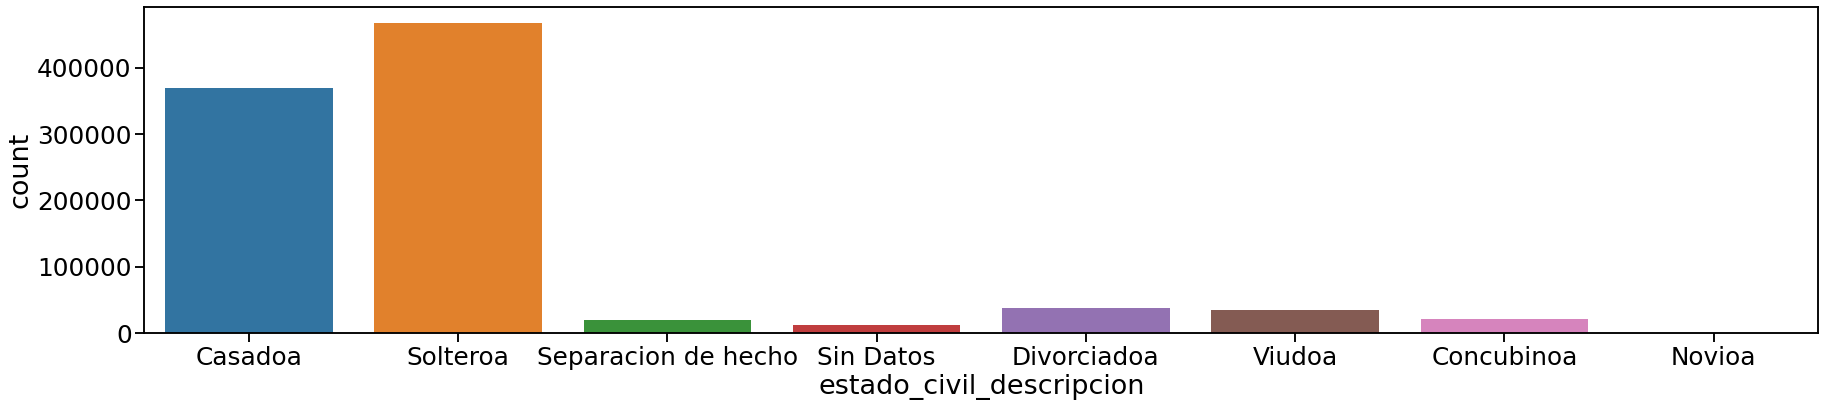

In [71]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x='estado_civil_descripcion')
plt.ticklabel_format(style='plain', axis='y')

`Separación de hecho` lo uniremos a `Divorciado/a`

`Concubino` lo uniremos a `Casado`

`Novio` lo unimos a `Sin Datos` (x su baja representación)

In [72]:
df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Separación de hecho', 'Divorciadoa')
df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Concubinoa', 'Casadoa')
df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Novioa', 'Sin Datos')

In [73]:
#Otra opcion analizada (3 Categorías):
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Separación de hecho', 'Otros')
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Viudo/a', 'Otros')
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Novio/a', 'Otros')
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Divorciado/a', 'Otros')
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Concubino/a', 'Casado/a')
#df_naranja_clean.loc[:, 'estado_civil_descripcion'] = df_naranja_clean.estado_civil_descripcion.str.replace('Sin Datos', 'Otros')

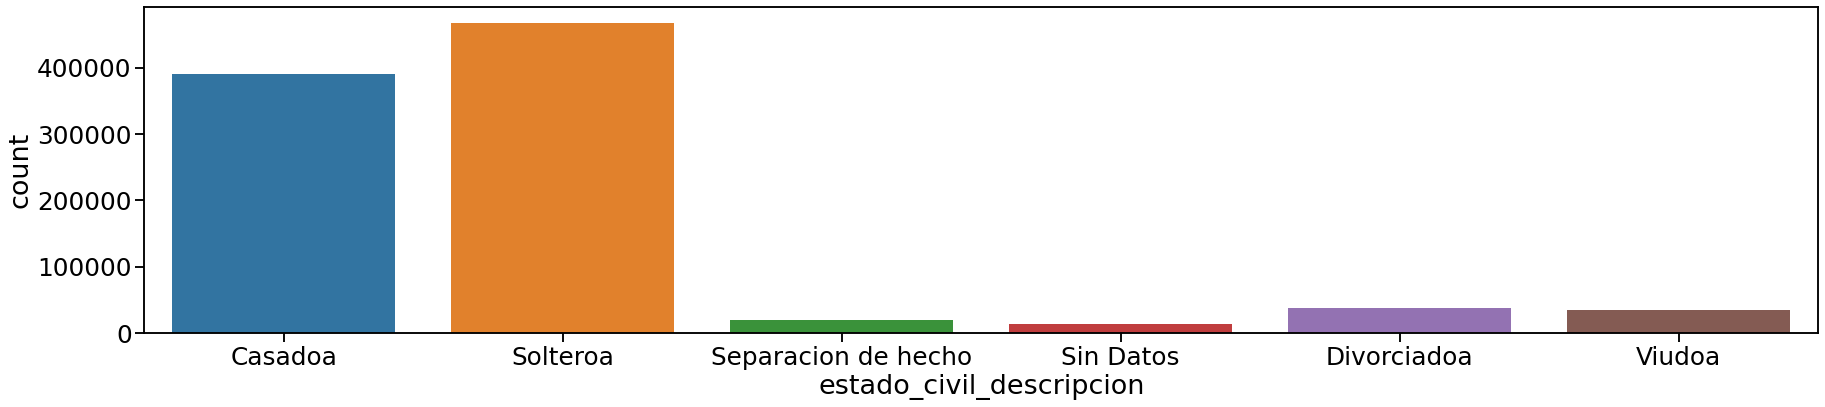

In [74]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x='estado_civil_descripcion')
plt.ticklabel_format(style='plain', axis='y')

#### Tipo de Producto

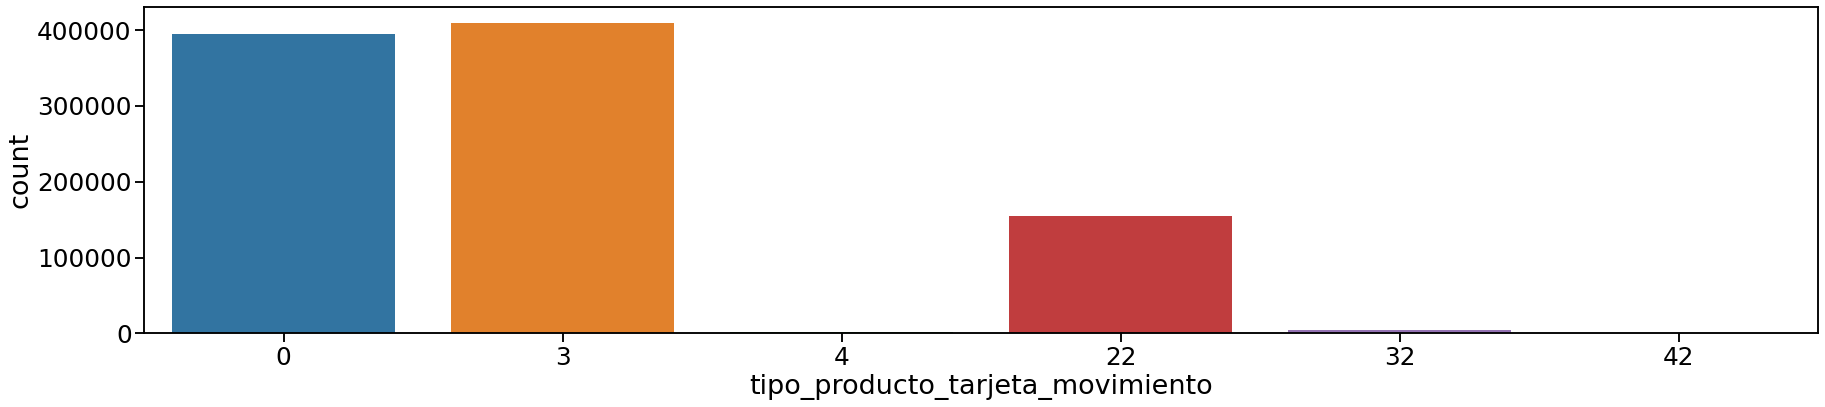

In [75]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x=tipo_producto)
plt.ticklabel_format(style='plain', axis='y')

In [76]:
df_naranja_clean.tipo_producto_tarjeta_movimiento.dtype

dtype('int64')

In [77]:
# Agrupamos las categorías menos frecuentes en el codigo 99 que va a ser Otros
df_naranja_clean.loc[:, tipo_producto] = df_naranja_clean.tipo_producto_tarjeta_movimiento.replace(4, 99)
df_naranja_clean.loc[:, tipo_producto] = df_naranja_clean.tipo_producto_tarjeta_movimiento.replace(32, 99)
df_naranja_clean.loc[:, tipo_producto] = df_naranja_clean.tipo_producto_tarjeta_movimiento.replace(42, 99)
df_naranja_clean.loc[:, tipo_producto] = df_naranja_clean.tipo_producto_tarjeta_movimiento.replace(22, 99)

**Codigo 99:** Para representar a Otros.

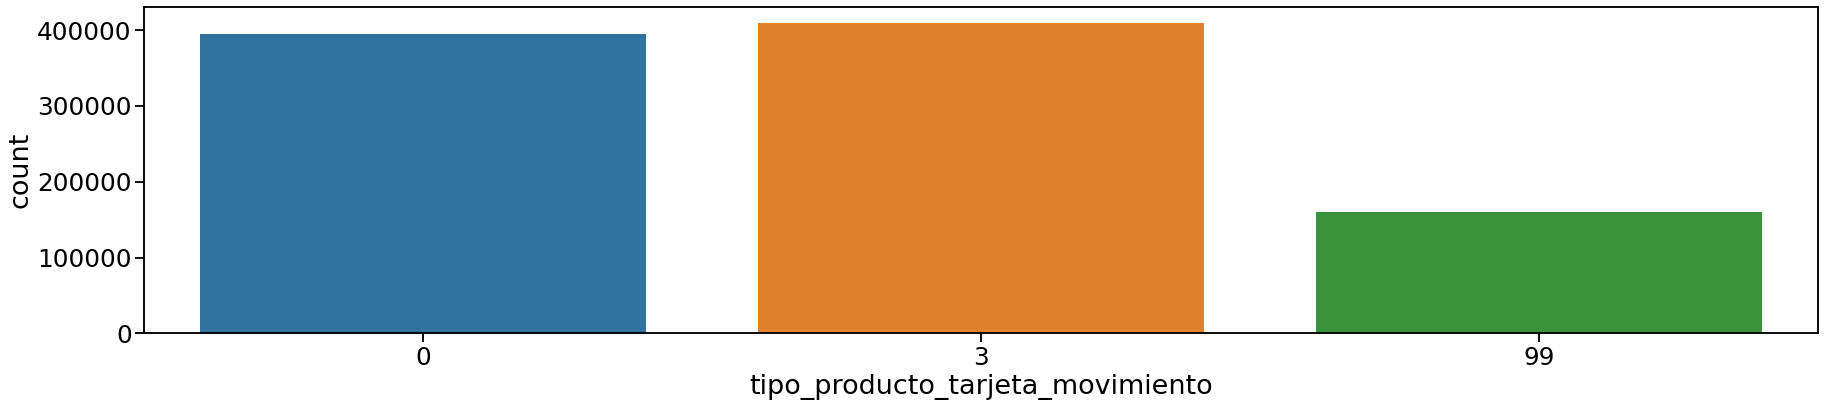

In [78]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x=tipo_producto)
plt.ticklabel_format(style='plain', axis='y')

#### Rel. Vivienda

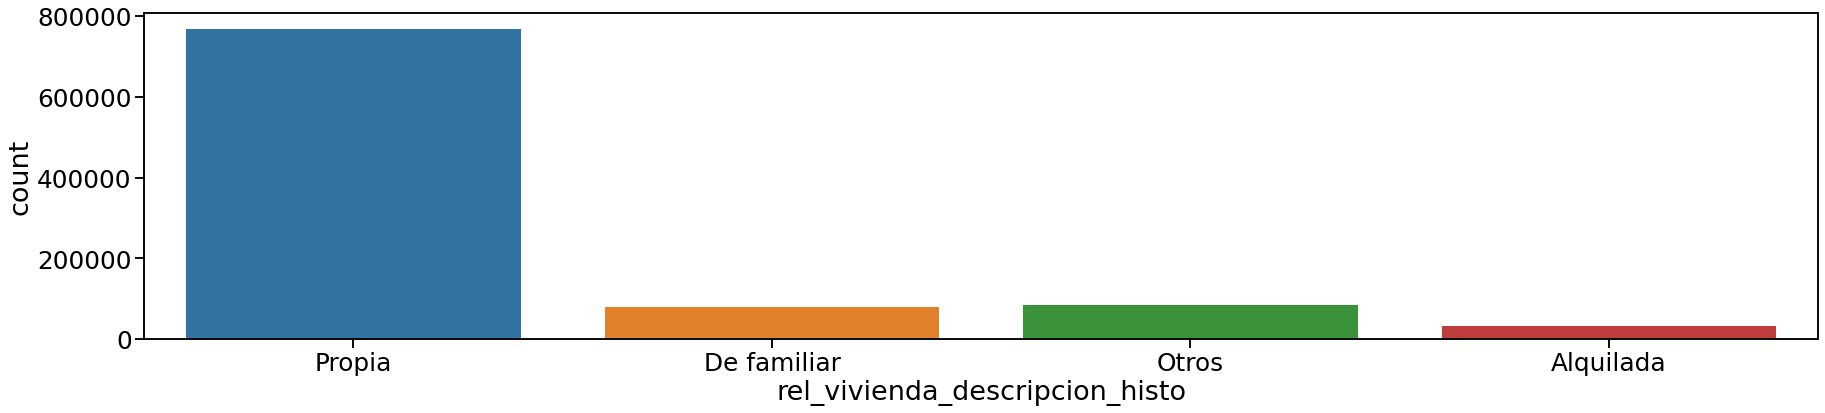

In [79]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x=rel_vivienda)
plt.ticklabel_format(style='plain', axis='y')

In [80]:
df_naranja_clean.loc[:, rel_vivienda] = df_naranja_clean.rel_vivienda_descripcion_histo.str.replace('De familiar', 'Otros')
df_naranja_clean.loc[:, rel_vivienda] = df_naranja_clean.rel_vivienda_descripcion_histo.str.replace('Alquilada', 'Otros')

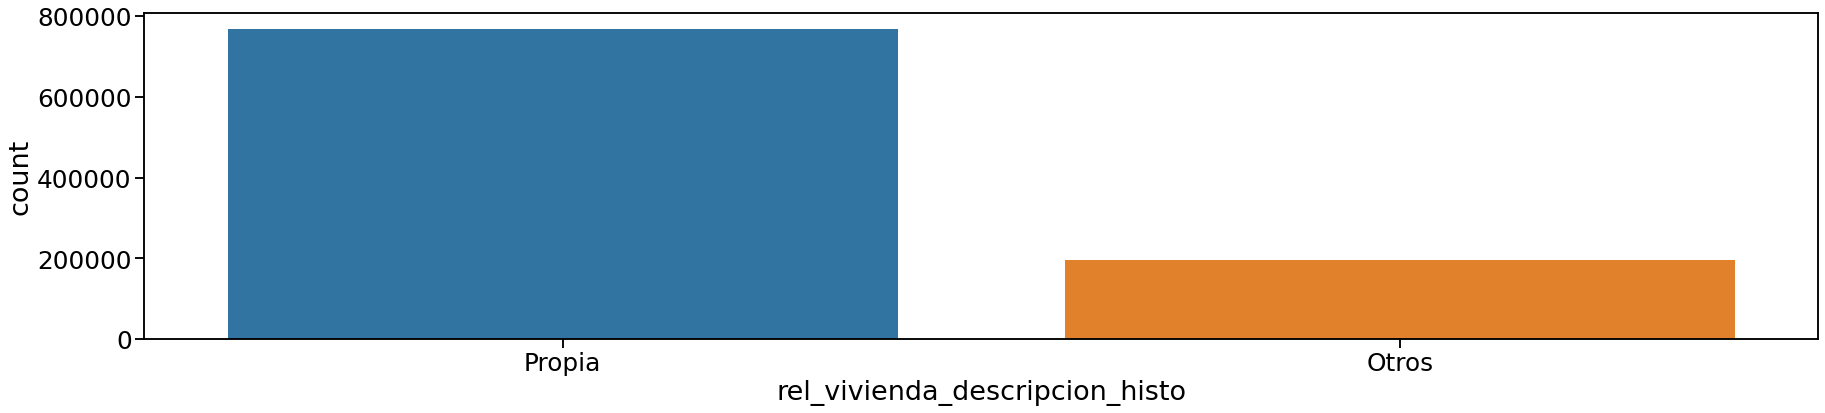

In [81]:
fig=plt.figure(figsize=(30,6))
sns.countplot(data=df_naranja_clean,x=rel_vivienda)
plt.ticklabel_format(style='plain', axis='y')

## C) Normalización y PCA

* Se puede normalizar la antiguedad y/o `monto_compra_movimiento`?
* Usando la edad y la antiguerdad hacer una analisis de PCA junto con la variables `monto_compra_movimiento`
  > pueden usar las 3 variables o hacer un analisis edad - monto y antiguedad - monto.

Se pueden normalizar tanto la antiguedad como el monto. Lo hacemos mediante Standard Scaler.

In [82]:
df_pca=df_naranja_clean[[edad,antiguedad,monto_normalizado]]
df_pca.head(4)

,edad,antig,monto_normalizado
0,32.0,54,84.55
1,32.0,54,293.54
2,32.0,54,339.55
3,32.0,54,8.61


In [83]:
n_components = 3

pca_estimator = PCA(n_components=n_components) 

pca_pipe_line = make_pipeline(StandardScaler(), pca_estimator)

result = pca_pipe_line.fit_transform(df_pca)
result

array([[-1.35829746, -0.298524  , -0.31363409],
       [-1.35327545, -0.23615224, -0.30732413],
       [-1.35216983, -0.22242085, -0.30593497],
       ...,
       [-0.74850943, -0.56663818, -0.02926088],
       [-0.74850943, -0.56663818, -0.02926088],
       [-0.74850943, -0.56663818, -0.02926088]])

In [84]:
#Varianza individual
explained_variance = pca_estimator.explained_variance_ratio_
explained_variance

array([0.46145513, 0.33381898, 0.20472588])

In [85]:
#Varianza Acumulada
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

array([ 46.15,  79.53, 100.  ])

In [86]:
scaled_dense_feature_matrix = df_pca
pca = PCA(n_components=3)
pca.fit(scaled_dense_feature_matrix)
proyected_features = pca.transform(scaled_dense_feature_matrix)
proyected_features.shape

(965065, 3)

In [87]:
df_pca[['pca1_scaled', 'pca2_scaled']] = proyected_features[:,:2]

<ipython-input-87-76341b501b26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca[['pca1_scaled', 'pca2_scaled']] = proyected_features[:,:2]
C:\Users\USUARIO\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<AxesSubplot:xlabel='pca1_scaled', ylabel='pca2_scaled'>

C:\Users\USUARIO\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


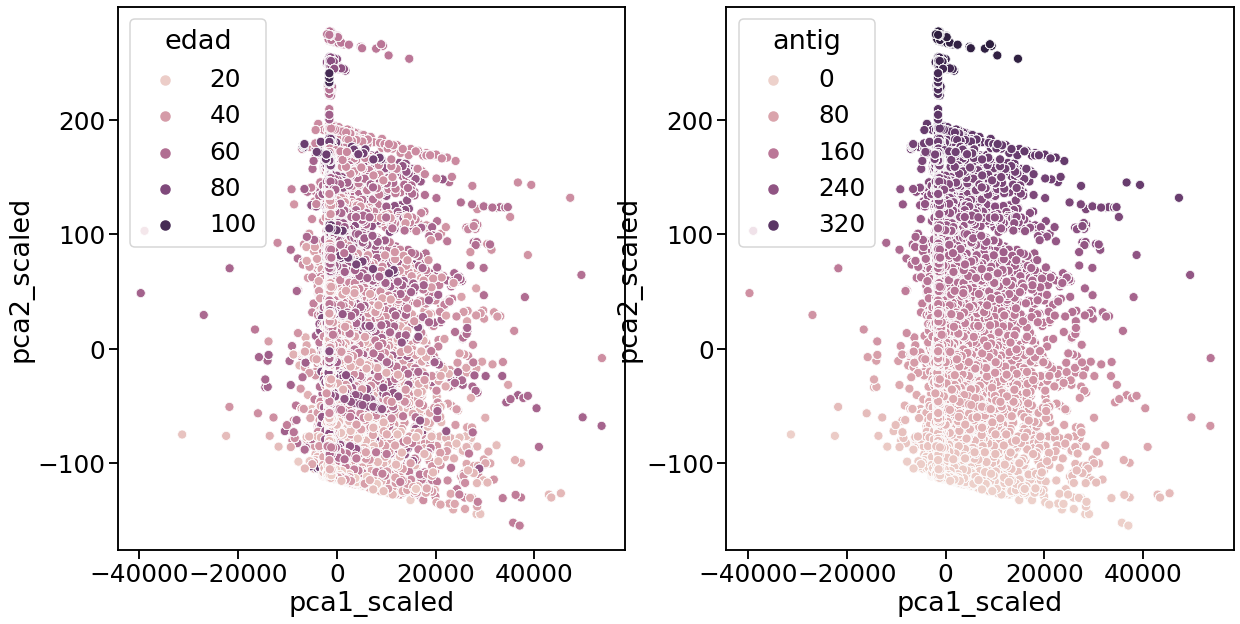

In [88]:
cols = ['edad', 'antig']
data = df_pca[cols + ['pca1_scaled', 'pca2_scaled']]#[:1000].dropna(how='any')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Other variables to try: 'Price' 'Landsize' 'Price' 'YearBuilt'
sns.scatterplot(data=data, x='pca1_scaled', y='pca2_scaled',
                    hue='edad', ax=axes[0])  
sns.scatterplot(data=data, x='pca1_scaled', y='pca2_scaled',
                    hue='antig', ax=axes[1]) 

**Conclusión**: Luego de aplicar PCA a las columnas monto_normalizado, edad y antiguedad podemos decir que en una variable, se encuentra explicada el 46,26% de la varianza de estas columnas, en 2 variables de pca, se encuentra explicado el 79,65% de su varianza. Y el total de la varianza se completa con la 3 variable de PCA. 

A traves del grafico se puede ver una relacion con la antiguedad.

## 4. Guardado
* Eliminar las columnas/filas que se consideren no necesarias, explicando el por que
* Codificar variables: todas las variables categóricas deben guardarse como variables numéricas, no string
* Comprimir el conjunto de datos para que se guarde en el formato más eficiente y comparalo contra `csv`.

#### DF Definitivo. - Columnas Eliminadas

- **nombre_comercio:** Usamos la columna Id. Comercio (agrupada en categorías) que contiene la misma información.
- **numero_cupon_movimiento:** numero cupón del movimiento, no se incluye en el analisis porque no aporte información relevante.
- **debito_credito_movimiento:** podemos precsindir de esta ya que en el sigo del monto encontramos la misma información.(+/-).
- **codigo_empresa_movimiento:** columna con 2 valores muy desproporcionada aprox 4 millones de movimientos en un valor, y 60 mil en el otro. Casi un valor único.
- **fecha_vto_cupon_movimiento:** utilizamos la fecha_cupon_movimiento.              
- **fecha_presentacion_movimiento:** utilizamos la fecha_cupon_movimiento.          
- **fecha_carga_sistema_movimiento:** utilizamos la fecha_cupon_movimiento, tiene la mitad de los valores faltantes.          
- **importe_cuota_movimiento:** mucha correlación con el monto. Nos quedamos con este ultimo.      
- **interes_movimiento:** no consideramos que sea el objetivo del analisis, ademas tenemos la columna plan_movimiento que nos ofrece información sobre las cuotas e implicitamente de su interes.       
- **cargo_adm_seguro_movimiento:** unico valor.
- **cargo_otorgamiento_movimiento:** unico valor.      
- **cargo_seguro_vida_movimiento:** unico valor.  
- **cargo_administrativo_movimient:** unico valor.           
- **seleccionado_ng:** unico valor.                          
- **tipo_prestamo_movimiento:** Contemplado dentro de la agrupación de id_comercio (cat 550)         
- **codigo_contable_movimiento:** no tiene relevancia en el analsis por se una cuestion administrativa interna de la empresa.
- **local_venta_producto:** Contemplado dentro de la agrupación de id_comercio.        
- **nombre_local_histo:** Contemplado dentro de la agrupación de id_comercio.                      
- **fecha_extraccion_movimiento**:utilizamos la fecha_cupon_movimiento.             
- **id_comercio_otras_marcas_movimiento:** Contemplado dentro de la agrupación de id_comercio.         
- **pais**: Único valor: Argentina.                                        
- **ciudad**:Agrupamos por provincia.                                      
- **domicilio_codigo_postal:** Agrupamos por provincia.                    
- **domicilio_barrio:** Agrupamos por provincia.                       


#### Columnas que por no tener variabilidad no las tendremos en cuenta:

- 'rango_edad'
- 'estado_civil_descripcion'
- 'sexo_descripcion'
- 'provincia'
- 'nivel_estudio_descripcion_histo'
- 'rel_vivienda_descripcion_histo'
- 'cargo_cat'

#### Codificación y escalado de Varriables:

In [89]:
df_naranja_clean.columns

Index(['dni_titular_movimiento', 'cat_comercio', 'producto_naranja_movimiento',
       'tipo_producto_tarjeta_movimiento', 'plan_movimiento', 'mes',
       'monto_normalizado', 'marca_debito_automatico', 'edad',
       'estado_civil_descripcion', 'sexo_descripcion', 'provincia', 'antig',
       'cargo_cat', 'nivel_estudio_descripcion_histo',
       'rel_vivienda_descripcion_histo', 'limit', 'rango_edad'],
      dtype='object')

In [90]:
df_naranja_clean.shape

(965065, 18)

In [91]:
#convierto numericas que en realidad son cateogricas.
df_naranja_clean.loc[:,'tipo_producto_tarjeta_movimiento']=df_naranja_clean.tipo_producto_tarjeta_movimiento.astype(str)
df_naranja_clean.loc[:,'plan_movimiento']=df_naranja_clean.plan_movimiento.astype(str)
df_naranja_clean.loc[:,'marca_debito_automatico']=df_naranja_clean.marca_debito_automatico.astype(str)

In [92]:
df_naranja_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965065 entries, 0 to 999870
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   dni_titular_movimiento            965065 non-null  object 
 1   cat_comercio                      965065 non-null  string 
 2   producto_naranja_movimiento       965065 non-null  object 
 3   tipo_producto_tarjeta_movimiento  965065 non-null  object 
 4   plan_movimiento                   965065 non-null  object 
 5   mes                               965065 non-null  object 
 6   monto_normalizado                 965065 non-null  float64
 7   marca_debito_automatico           965065 non-null  object 
 8   edad                              965065 non-null  float64
 9   estado_civil_descripcion          965065 non-null  object 
 10  sexo_descripcion                  965065 non-null  object 
 11  provincia                         965065 non-null  o

In [93]:
ignored_cols = ['dni_titular_movimiento', 'mes', 'edad', 'limit', 'antig2', 'rango_edad','estado_civil_descripcion','sexo_descripcion','provincia','nivel_estudio_descripcion_histo'
,'rel_vivienda_descripcion_histo','cargo_cat']
categorical_cols = ['producto_naranja_movimiento','cat_comercio','tipo_producto_tarjeta_movimiento','plan_movimiento', 'marca_debito_automatico']
numerical_cols = ['monto_normalizado','antig']

df_naranja_clean[categorical_cols].nunique()

producto_naranja_movimiento         12
cat_comercio                        10
tipo_producto_tarjeta_movimiento     3
plan_movimiento                     11
marca_debito_automatico              2
dtype: int64

In [94]:
#No lo vamos a utilizar
# convertimos a tipo de dato correcto.
#df_naranja_clean.loc[:, 'plan_movimiento'] = df_naranja_clean['plan_movimiento'].astype('string')

In [95]:
feature_cols = categorical_cols + numerical_cols
features = list(df_naranja_clean[feature_cols].T.to_dict().values())

vectorizer = feature_extraction.DictVectorizer(sparse=False)
feature_matrix = vectorizer.fit_transform(features)
feature_matrix

array([[54.,  1.,  0., ...,  1.,  0.,  0.],
       [54.,  1.,  0., ...,  1.,  0.,  0.],
       [54.,  1.,  0., ...,  1.,  0.,  0.],
       ...,
       [72.,  1.,  0., ...,  1.,  0.,  0.],
       [72.,  1.,  0., ...,  1.,  0.,  0.],
       [72.,  1.,  0., ...,  1.,  0.,  0.]])

In [96]:
feature_names = vectorizer.get_feature_names()

In [97]:
#Escalado
#matriz_densa = preprocessing.MaxAbsScaler().fit_transform(feature_matrix)
matriz_densa=feature_matrix

In [98]:
matriz_densa_completa = np.hstack([matriz_densa, df_naranja_clean[[dni]].values])
matriz_densa_completa
#Alternativa por mes
#matriz_densa_completa = np.hstack([matriz_densa, df_naranja_clean[[dni,mes_año]].values]) 

array([[54.0, 1.0, 0.0, ..., 0.0, 0.0,
        '00060322d46ef99decf79257957b934d413'],
       [54.0, 1.0, 0.0, ..., 0.0, 0.0,
        '00060322d46ef99decf79257957b934d413'],
       [54.0, 1.0, 0.0, ..., 0.0, 0.0,
        '00060322d46ef99decf79257957b934d413'],
       ...,
       [72.0, 1.0, 0.0, ..., 0.0, 0.0,
        '000b0b6905ca172cb064331c76663c00147'],
       [72.0, 1.0, 0.0, ..., 0.0, 0.0,
        '000b0b6905ca172cb064331c76663c00147'],
       [72.0, 1.0, 0.0, ..., 0.0, 0.0,
        '000b0b6905ca172cb064331c76663c00147']], dtype=object)

In [99]:
matriz_densa_df = pd.DataFrame(data=matriz_densa_completa, columns=feature_names+['dni'])

#Alternativa por mes
#matriz_densa_df = pd.DataFrame(data=matriz_densa_completa, columns=feature_names+['dni','mes']) 

matriz_densa_df

,antig,cat_comercio=0,cat_comercio=1,cat_comercio=2,cat_comercio=3,cat_comercio=4,cat_comercio=5,cat_comercio=6,cat_comercio=7,cat_comercio=8,...,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=SM,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=99,dni
0,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,00060322d46ef99decf79257957b934d413
1,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,00060322d46ef99decf79257957b934d413
2,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,00060322d46ef99decf79257957b934d413
3,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,00060322d46ef99decf79257957b934d413
4,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,00060322d46ef99decf79257957b934d413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965060,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,000b0b6905ca172cb064331c76663c00147
965061,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,000b0b6905ca172cb064331c76663c00147
965062,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,000b0b6905ca172cb064331c76663c00147
965063,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,000b0b6905ca172cb064331c76663c00147


#### Agrupamiento de Filas:

Agrupamos las filas por **clientes**, esto nos va a dar un resultado de 1 fila por cliente.
Para que esta agrupación tenga sentido tenemos que separar las variables en 2 tipos:
- Las que van a sumar su resultado. (Ej: sumar montos, movimientos por producto) 
- Las que no tiene sentido sumar su resultado y por ser un unico valor siempre,  se una la moda para solucionar este inconveniente). (Ej: sumar Hombre no tiene sentido)

Tenemos que sumar todas estas variables:
* 'producto_naranja_movimiento'
* 'tipo_producto_tarjeta_movimiento'
* 'marca_debito_automatico'
* 'cat_comercio'
* 'plan_movimiento'
* 'monto_normalizado'

Para el resto usaremos el valor más frecuente:
* 'rango_edad'
* 'estado_civil_descripcion'
* 'sexo_descripcion'
* 'provincia'
* 'rango_antig'
* 'cargo_cat'
* 'nivel_estudio_descripcion_histo'
* 'rel_vivienda_descripcion_histo'

In [100]:
matriz_densa_df.columns

Index(['antig', 'cat_comercio=0', 'cat_comercio=1', 'cat_comercio=2',
       'cat_comercio=3', 'cat_comercio=4', 'cat_comercio=5', 'cat_comercio=6',
       'cat_comercio=7', 'cat_comercio=8', 'cat_comercio=9',
       'marca_debito_automatico=0', 'marca_debito_automatico=1',
       'monto_normalizado', 'plan_movimiento=1', 'plan_movimiento=10',
       'plan_movimiento=11', 'plan_movimiento=12', 'plan_movimiento=2',
       'plan_movimiento=3', 'plan_movimiento=4', 'plan_movimiento=5',
       'plan_movimiento=6', 'plan_movimiento=8', 'plan_movimiento=9',
       'producto_naranja_movimiento=AV', 'producto_naranja_movimiento=AX',
       'producto_naranja_movimiento=EX', 'producto_naranja_movimiento=MC',
       'producto_naranja_movimiento=PC', 'producto_naranja_movimiento=PL',
       'producto_naranja_movimiento=PN', 'producto_naranja_movimiento=PP',
       'producto_naranja_movimiento=SM', 'producto_naranja_movimiento=TA',
       'producto_naranja_movimiento=VI', 'producto_naranja_movimien

In [101]:
cols_to_most_frequent=[
    'rango_edad',
    'estado_civil_descripcion',
    'sexo_descripcion',
    'provincia',
    'rango_antig',
    'cargo_cat',
    'nivel_estudio_descripcion_histo',
    'rel_vivienda_descripcion_histo'
]
cols_to_sum = [
    'producto_naranja_movimiento', 
    'tipo_producto_tarjeta_movimiento', 
    'marca_debito_automatico',
    'cat_comercio',
    'plan_movimiento',
    'monto_normalizado'
              ]
aggregations = {}
for col in cols_to_most_frequent:
    for feature_name in feature_names:
        if col in feature_name:
            #pass
            aggregations[feature_name] = lambda x: x.mode()
for col in cols_to_sum:
    for feature_name in feature_names:
        if col in feature_name:
            aggregations[feature_name] = 'sum'
aggregations

{'producto_naranja_movimiento=AV': 'sum',
 'producto_naranja_movimiento=AX': 'sum',
 'producto_naranja_movimiento=EX': 'sum',
 'producto_naranja_movimiento=MC': 'sum',
 'producto_naranja_movimiento=PC': 'sum',
 'producto_naranja_movimiento=PL': 'sum',
 'producto_naranja_movimiento=PN': 'sum',
 'producto_naranja_movimiento=PP': 'sum',
 'producto_naranja_movimiento=SM': 'sum',
 'producto_naranja_movimiento=TA': 'sum',
 'producto_naranja_movimiento=VI': 'sum',
 'producto_naranja_movimiento=ZE': 'sum',
 'tipo_producto_tarjeta_movimiento=0': 'sum',
 'tipo_producto_tarjeta_movimiento=3': 'sum',
 'tipo_producto_tarjeta_movimiento=99': 'sum',
 'marca_debito_automatico=0': 'sum',
 'marca_debito_automatico=1': 'sum',
 'cat_comercio=0': 'sum',
 'cat_comercio=1': 'sum',
 'cat_comercio=2': 'sum',
 'cat_comercio=3': 'sum',
 'cat_comercio=4': 'sum',
 'cat_comercio=5': 'sum',
 'cat_comercio=6': 'sum',
 'cat_comercio=7': 'sum',
 'cat_comercio=8': 'sum',
 'cat_comercio=9': 'sum',
 'plan_movimiento=1': '

In [102]:
grouped_matriz_densa_df = matriz_densa_df \
    .groupby(['dni']) \
    .agg(
        aggregations
    )

# Alternativa por mes:
#grouped_matriz_densa_df = matriz_densa_df \
#    .groupby(['dni','mes']) \
#    .agg(
#        aggregations
#    )

In [103]:
df_guardado= pd.DataFrame(grouped_matriz_densa_df.reset_index())
df_guardado

,dni,producto_naranja_movimiento=AV,producto_naranja_movimiento=AX,producto_naranja_movimiento=EX,producto_naranja_movimiento=MC,producto_naranja_movimiento=PC,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=SM,...,plan_movimiento=11,plan_movimiento=12,plan_movimiento=2,plan_movimiento=3,plan_movimiento=4,plan_movimiento=5,plan_movimiento=6,plan_movimiento=8,plan_movimiento=9,monto_normalizado
0,000000b5aea2c9ea7cc155f6ebcef97f826,0.0,0.0,0.0,0.0,0.0,179.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1142.35
1,00000b8415f19846d12e852ebd0d52ec432,167.0,0.0,0.0,0.0,20.0,999.0,0.0,0.0,159.0,...,0.0,15.0,0.0,45.0,0.0,0.0,29.0,0.0,20.0,2839335.84
2,00000d109ca5a0c6b3e76295f0292c38189,0.0,0.0,0.0,0.0,0.0,197.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-106.06
3,000017309738c042c2ec144d5d3d3632673,142.0,0.0,0.0,0.0,0.0,486.0,0.0,0.0,170.0,...,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,1665704.92
4,00001b02afa8956b08af05c339039882046,0.0,0.0,0.0,0.0,0.0,2399.0,0.0,0.0,171.0,...,0.0,0.0,0.0,0.0,16.0,32.0,30.0,0.0,0.0,1639227.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,000ef071e95351afc1149fa1afe4862a079,0.0,0.0,0.0,0.0,0.0,1729.0,0.0,14.0,179.0,...,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,5335364.29
840,000ef0bc6859b57ec9cc7db583dd73ca697,0.0,0.0,0.0,0.0,0.0,671.0,0.0,0.0,187.0,...,0.0,0.0,20.0,43.0,0.0,0.0,16.0,0.0,0.0,1330969.72
841,000ef64a5f2323a3979805450f2e890c495,0.0,0.0,0.0,0.0,0.0,942.0,0.0,0.0,159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1455454.27
842,000eff02871f717d5c860eae9e0347a5523,0.0,0.0,0.0,0.0,0.0,1079.0,0.0,0.0,0.0,...,0.0,0.0,40.0,37.0,0.0,0.0,0.0,0.0,0.0,1057173.63


In [104]:
df_guardado.dtypes

dni                                     object
producto_naranja_movimiento=AV         float64
producto_naranja_movimiento=AX         float64
producto_naranja_movimiento=EX         float64
producto_naranja_movimiento=MC         float64
producto_naranja_movimiento=PC         float64
producto_naranja_movimiento=PL         float64
producto_naranja_movimiento=PN         float64
producto_naranja_movimiento=PP         float64
producto_naranja_movimiento=SM         float64
producto_naranja_movimiento=TA         float64
producto_naranja_movimiento=VI         float64
producto_naranja_movimiento=ZE         float64
tipo_producto_tarjeta_movimiento=0     float64
tipo_producto_tarjeta_movimiento=3     float64
tipo_producto_tarjeta_movimiento=99    float64
marca_debito_automatico=0              float64
marca_debito_automatico=1              float64
cat_comercio=0                         float64
cat_comercio=1                         float64
cat_comercio=2                         float64
cat_comercio=

#### Guardado

In [105]:
#No lo vamos a usar por el momento:

#def remove_arrays_from_column(value):
#    val = value[0]
#    isfloat = isinstance(value, float)
#    if isfloat:
#        return value
#    else:
#        return max(value[0], value[0])

In [106]:
#No lo vamos a usar por el momento:

#df_guardado.loc[:, 'rango_edad=57, 67'] = df_guardado[['rango_edad=57, 67']].apply(remove_arrays_from_column).astype('float64')
#df_guardado.loc[:, 'rango_edad=67, 77'] = df_guardado[['rango_edad=67, 77']].apply(remove_arrays_from_column).astype('float64')
#df_guardado.loc[:, 'rango_antig=4, 9'] = df_guardado[['rango_antig=4, 9']].apply(remove_arrays_from_column).astype('float64')
#df_guardado.loc[:, 'rango_antig=9, 14'] = df_guardado[['rango_antig=9, 14']].apply(remove_arrays_from_column).astype('float64')

In [107]:
df_guardado.to_parquet('myfile.parquet', engine='fastparquet')

## 5. Optativos
En Big data se manejan datos crudos todo el tiempo y de gran volumen, este proceso de exploracion y limpieza
es parte del proceso conocido como ETL (Extract, transform, load) o ELT (Extract, load, transform). 
Todo el proceso de este tp pertenece a la etapa de Transfom. En big data esto se hace de manera automatizada. 

* Entonces como asegurarse que los datos son saludables?.
  Es decir que no contengan valores atipicos, nulls, tipos de datos incorrectos, etc.
  No podemos hacer validaciones a mano si tenemos miles de datos por dia/hora.
  > Hint: [great expectations](https://greatexpectations.io/)
* Documentar las columnas finales. (procesos aplicados en este tp)
